In [1]:
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.colors as colors
from matplotlib.colors import BoundaryNorm, LogNorm

import cmocean 
import numpy as np
import numpy.ma as ma
import os 
import xarray as xr
import pandas as pd
import datetime
import warnings
warnings.filterwarnings("ignore")
import pyproj
import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cpf
from cartopy.feature import NaturalEarthFeature, LAND, COASTLINE
from cartopy.mpl.gridliner import LATITUDE_FORMATTER, LONGITUDE_FORMATTER
from datetime import datetime, timedelta
import os, fnmatch, glob
from netCDF4 import Dataset as ncfile

import LambertLabels

/home/maltem/.local/lib/python3.10/site-packages/pandas/core/arrays/masked.py:62: UserWarning: Pandas requires version '1.3.4' or newer of 'bottleneck' (version '1.3.2' currently installed).
  from pandas.core import (


In [2]:
def findindex(alat,alon,plat,plon):
    #finding identical location of pos plat, plon in array alat[],alon[]
    abslat = np.abs(alat-plat)
    abslon = np.abs(alon-plon)
    c = np.maximum(abslon,abslat)
    #latlon_idx = np.argmin(c)
    x, y = np.where(c == np.min(c))
    #print(alats[x,y],alon[x,y])
    x=int(x)
    y=int(y)
    return (x,y)

In [3]:
# Dummy AROME Arctic GRID
arch_dir='../../python/data/basicAA/'
GRIDdummy = xr.open_mfdataset(arch_dir+'mean.diff.SFX_ICE_THK.basic_aa_new-amsr2.Mar2019.nc')
alat=np.array(GRIDdummy['latitude'])
alon=np.array(GRIDdummy['longitude'])

#Input AROME Arctic File reduced to MIZ
AAbox = xr.open_mfdataset('data/AromeArctic/box.fc.diag.svalmiz2024.nc')
aboxlat=np.array(AAbox['latitude'])
aboxlon=np.array(AAbox['longitude'])
#Input OMB data
OMBraw = xr.open_mfdataset('data/cruise/2024_KVS_deployment.nc')

## Read all buoys

In [4]:
#for buoyID in OMBraw.trajectory:
#    print(np.array(buoyID))
#    OMB_instrument = OMBraw.sel(trajectory=buoyID)
#    print((OMB_instrument.time))

In [5]:
#Find all times closer than 29 minutes
timenow = OMB_instrument.time[0]

timemask = np.int32(np.abs(np.array(OMBraw.time-timenow)).astype('timedelta64[m]'))<15

NameError: name 'OMB_instrument' is not defined

In [6]:
#Find all buoy coordinates at a certain time
for buoy_no in range(np.min(np.shape(timemask))):
    tb = np.where(timemask[buoy_no,:])
    if tb[0]:
        print(np.array(OMBraw.time[buoy_no,np.array(tb[0])]),  np.array(OMBraw.lon[buoy_no,np.array(tb[0])]),np.array(OMBraw.lat[buoy_no,np.array(tb[0])]))
    

NameError: name 'timemask' is not defined

## Plot a map timeslice

NameError: name 'hs' is not defined

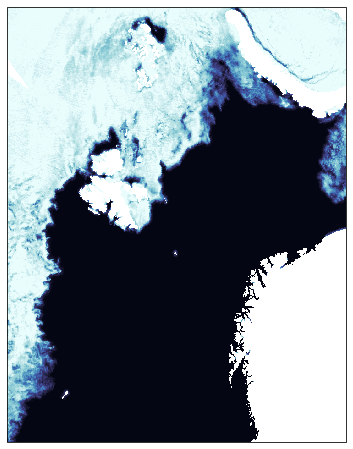

In [7]:
dir_seaiceproduct_hres= '/lustre/storeB/project/fou/hi/oper/barents_eps/archive/obs/'
file_name_stub         = 'barents_icec-obs_%s' #barents_icec-obs_20240415T00Z.nc

date = datetime.strptime('2024-04-26 01:00:00','%Y-%m-%d %H:%M:%S') 

#------------------------------------------------------------#
#Find all buoys at date times closer than 29 minutes
timenow = np.datetime64(date)
timemask = np.int32(np.abs(np.array(OMBraw.time-timenow)).astype('timedelta64[m]'))<10

#------------------------------------------------------------#
# Load SeaIce             -----------------------------------#

datetime_str = datetime.strftime(date, '%Y%m%d')
file_prename = file_name_stub % datetime_str
infile_name = glob.glob(dir_seaiceproduct_hres + file_prename + '*.nc')
if infile_name:
    IceIn = xr.open_mfdataset(infile_name)
    lats = np.array(IceIn['lat'])
    lons = np.array(IceIn['lon'])
    sicn = np.array(IceIn['ice_conc'])
   # sicn=np.where(sicn<1,np.nan,sicn)

#------------------------------------------------------------#
# Input AROME Arctic File reduced to MIZ
AAbox = xr.open_mfdataset('data/AromeArctic/box.fc.diag.svalmiz2024.nc')
aboxlat=np.array(AAbox['latitude'])
aboxlon=np.array(AAbox['longitude'])




#  ---------- FIGURE ---------- #
map_proj = ccrs.LambertConformal(central_latitude=77.5,
                                 central_longitude=-25,
                                 standard_parallels=(77.5,77.5))
PRJ = pyproj.Proj(map_proj.proj4_init)
x0,y0 = PRJ(alon[480,80],alat[480,80])
x1,y1 = PRJ(alon[650,280],alat[650,280])
LAND_highres = cpf.NaturalEarthFeature('physical', 'land', '50m', edgecolor='face', \
                                       facecolor = 'darkgrey', linewidth=.1)
sizefont = 18
ice_cmap = colors.ListedColormap(['none','grey'])
ice_levels = np.linspace(0,1,3)
ice_norm = BoundaryNorm(ice_levels, 31)
xticks = [-20,-10, -8,-6,-4,-2,0,2,4,6,8,10,12,14,16,18,20,22,24,26,28,30,32,34,36,38,40,50,60,70,80,90,100,110,120]
yticks = [60,65,70, 75,76,77,78,79,80,81,82,83, 85,90]

fig, axs = plt.subplots(1,1, figsize=(8,8), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = 0.1, wspace=0.3)

levels = np.linspace(0.,100 , 31)  # color bar
lticks =np.arange(0, 100+10, 10)
norm = BoundaryNorm(levels, 256)
colorscale = 'cmo.ice'

axs = plt.subplot(1,1,1, projection = map_proj)
axs.set_title('', fontsize = sizefont)

iceplot = axs.pcolormesh(lons,lats,np.squeeze(np.array(sicn))*100., cmap=cmocean.cm.ice, transform = ccrs.PlateCarree())
# Plot the variable hs using xarray's plot method
hs.plot.pcolormesh(ax=axs, transform=rotated_pole_90, cmap='viridis')

for buoy_no in range(np.min(np.shape(timemask))):
    tb = np.where(timemask[buoy_no,:]); #tb = [x[0] for x in tb1]
    if tb:
        #print(np.array(OMBraw.time[buoy_no,np.array(tb[0])]),  np.array(OMBraw.lon[buoy_no,np.array(tb[0])]),np.array(OMBraw.lat[buoy_no,np.array(tb[0])]))
        axs.scatter(OMBraw.lon[buoy_no,np.array(tb[0])],OMBraw.lat[buoy_no,np.array(tb[0])],color='r',marker='o',transform = ccrs.PlateCarree())




axs.add_feature(LAND_highres, zorder = 1, alpha = 1.0)

cb = plt.colorbar(iceplot, ax=axs, orientation='horizontal', extend='both')
cb.set_label('in %', size=14)
cb.ax.tick_params(labelsize=12)
axs.set_xlim(x0,x1)
axs.set_ylim(y0,y1)

## Loop hourly, with sea-ice, waves, and buoys

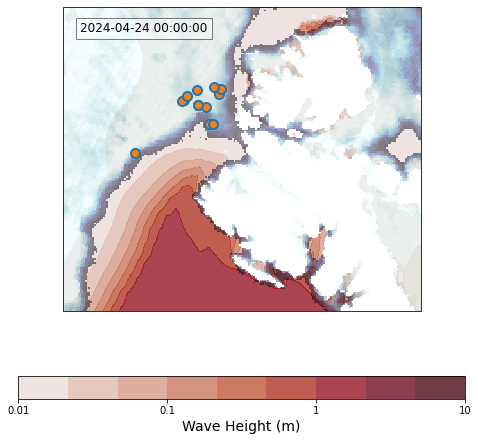

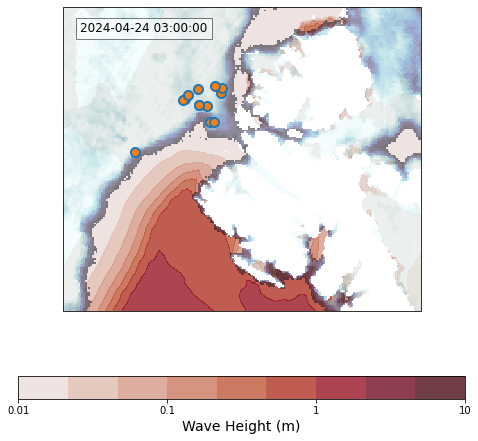

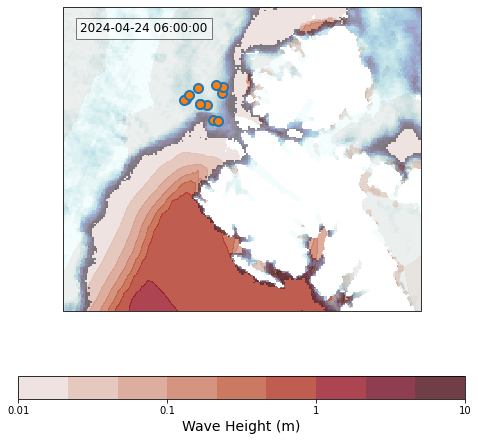

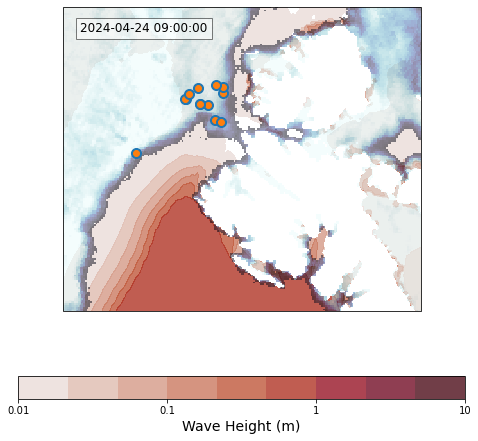

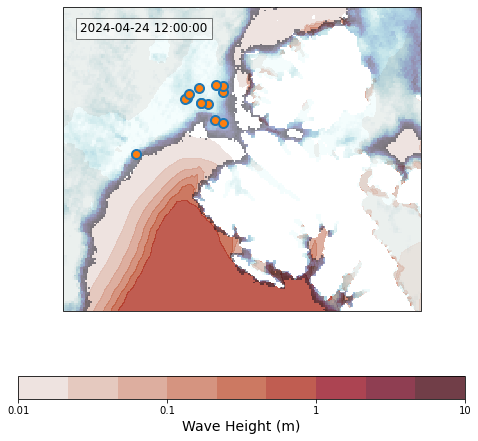

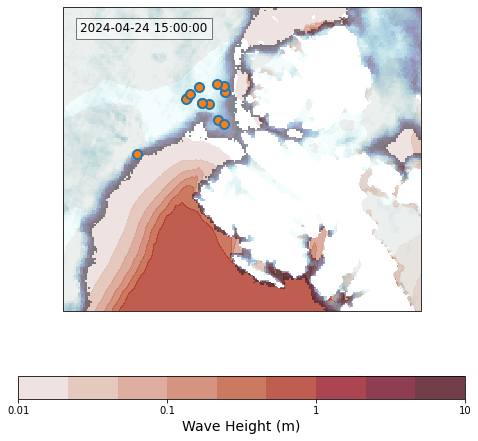

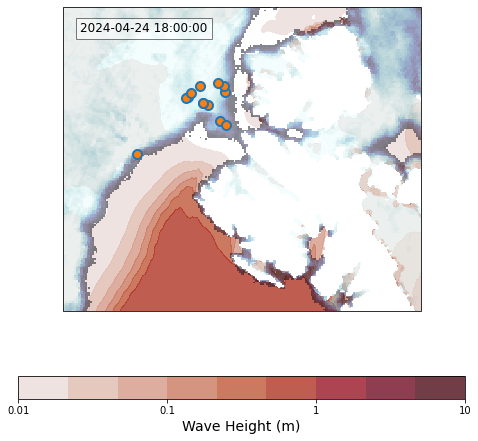

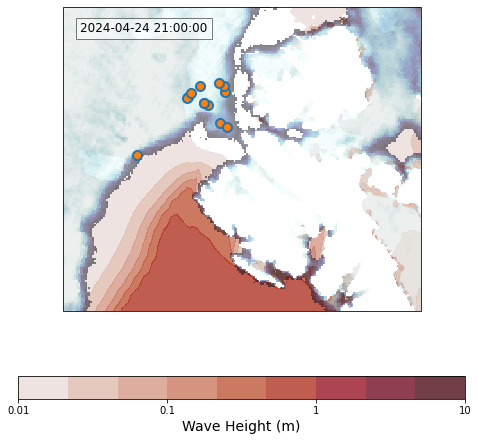

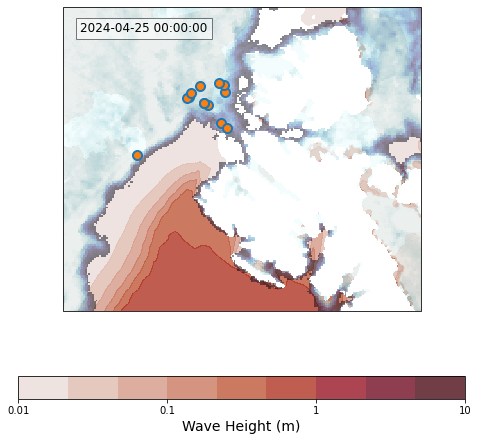

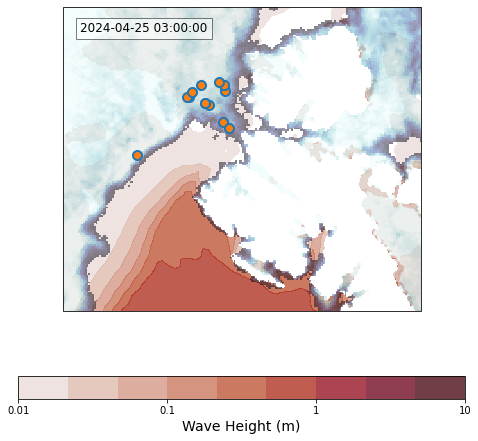

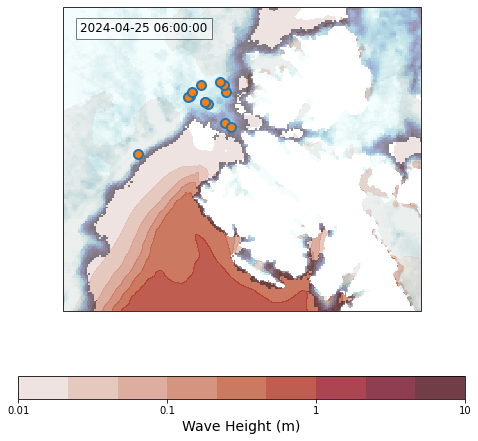

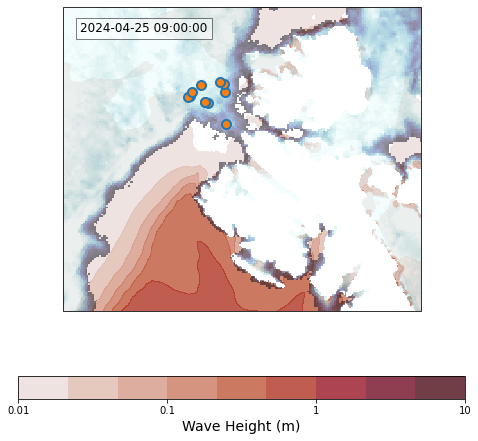

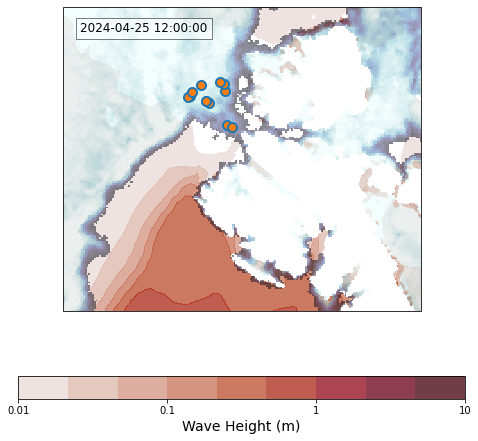

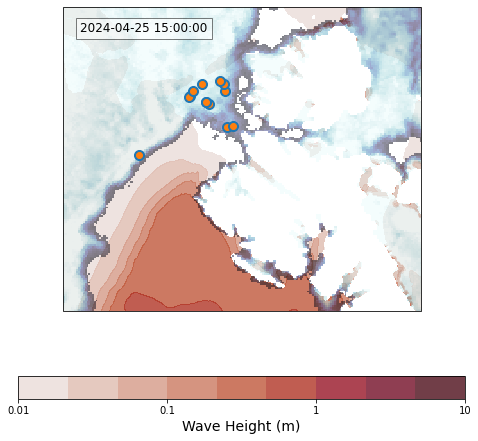

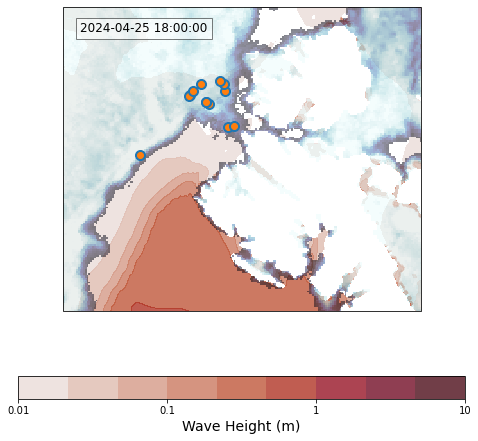

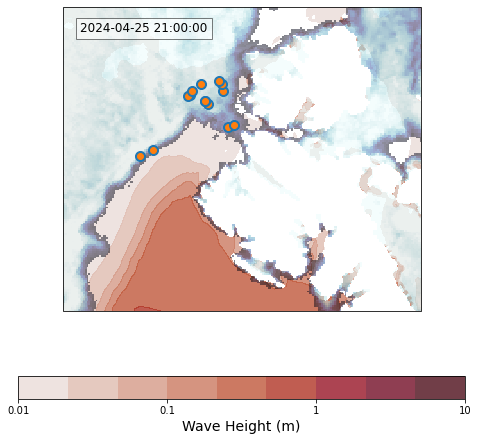

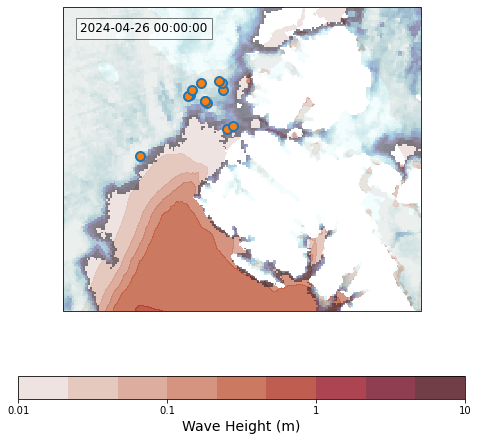

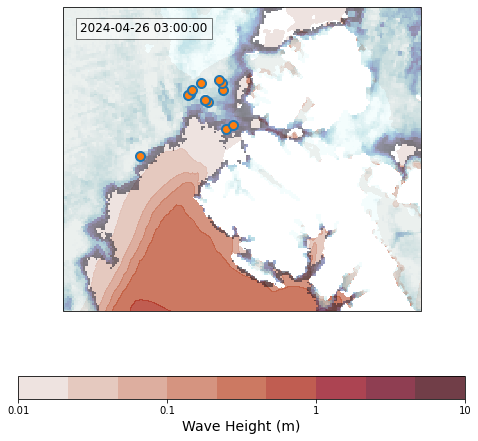

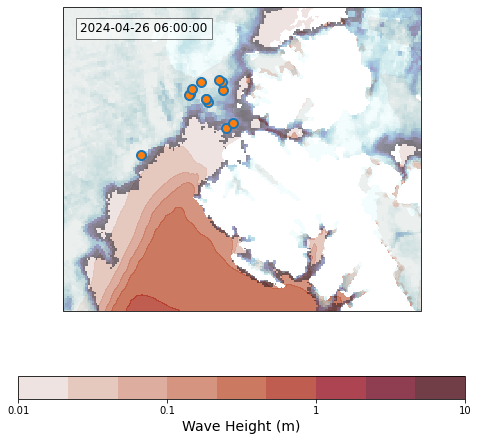

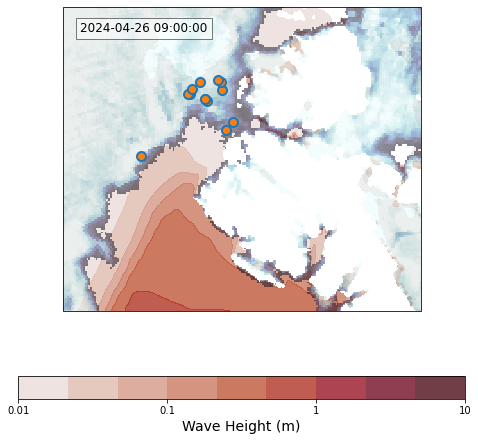

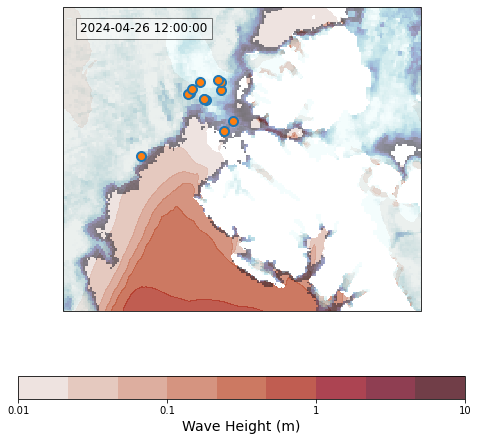

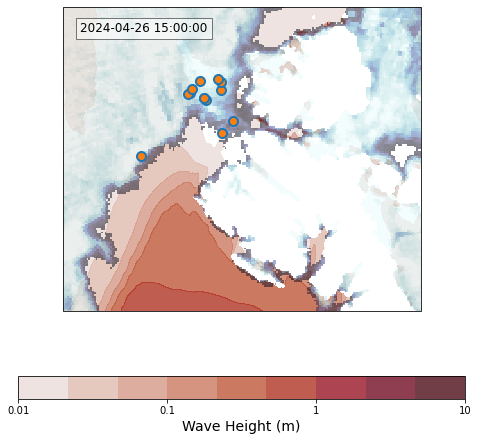

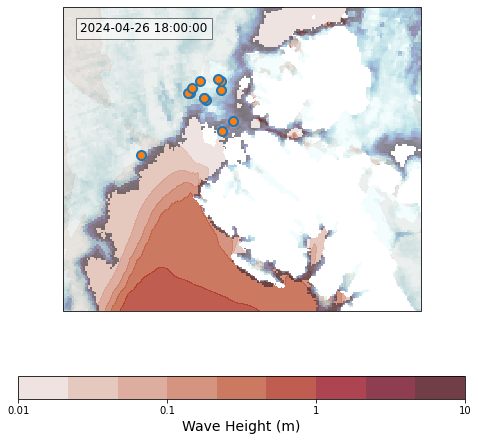

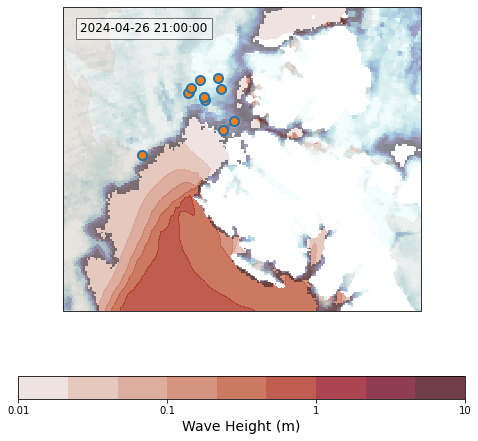

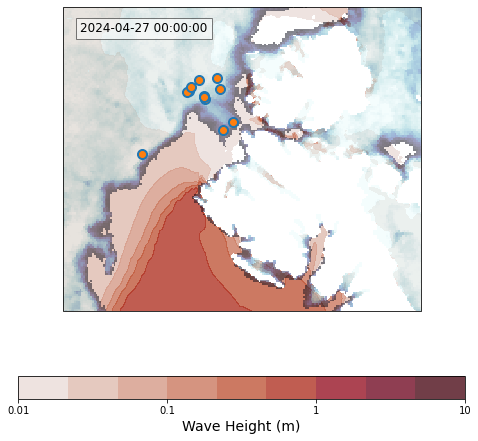

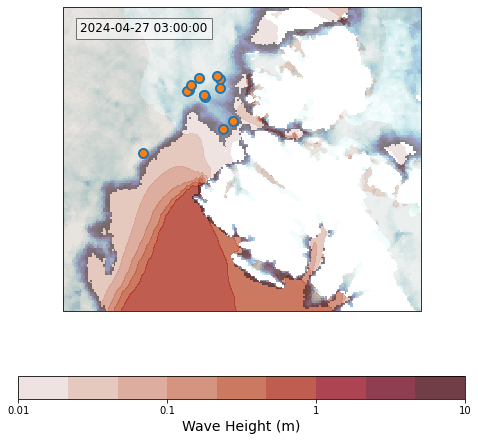

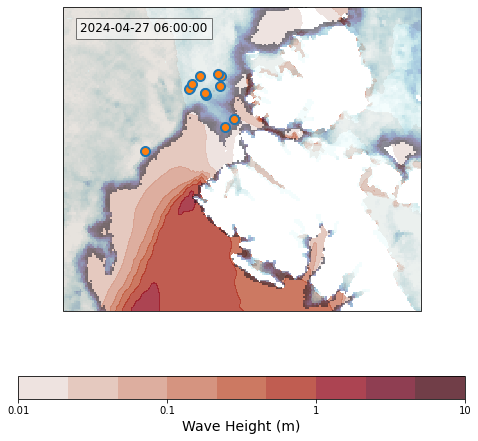

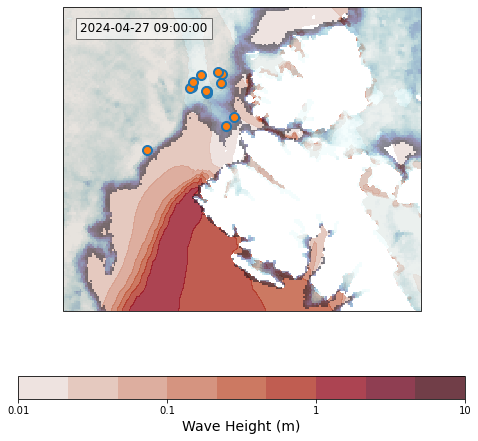

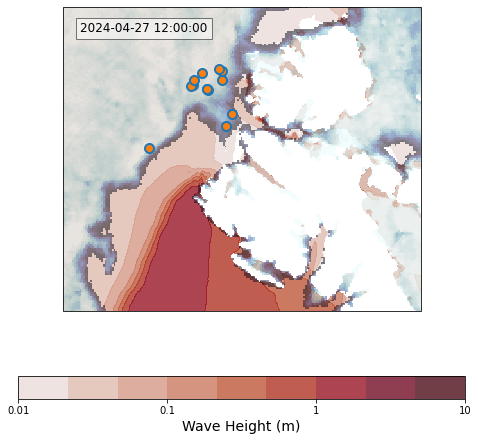

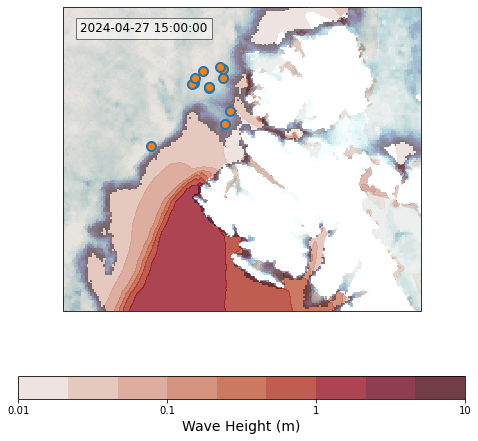

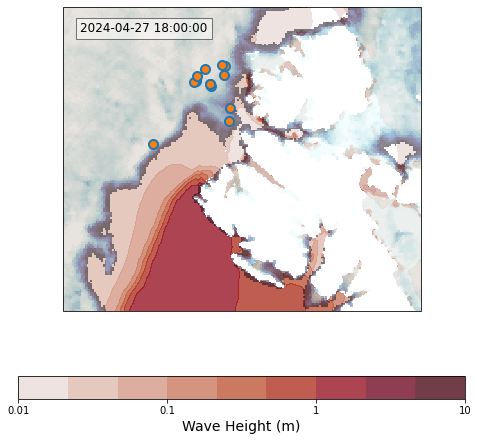

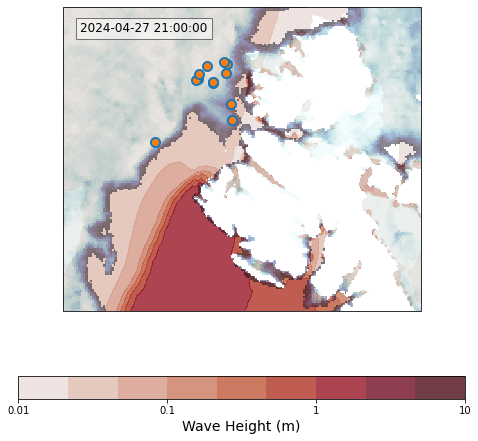

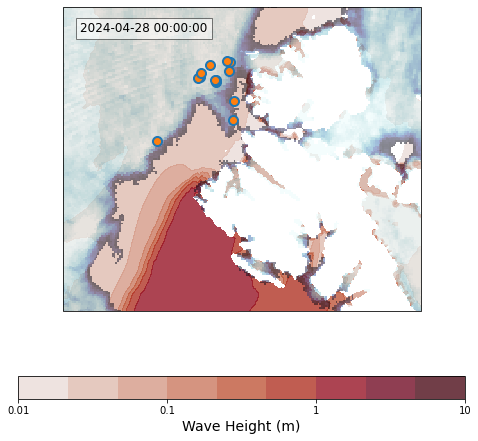

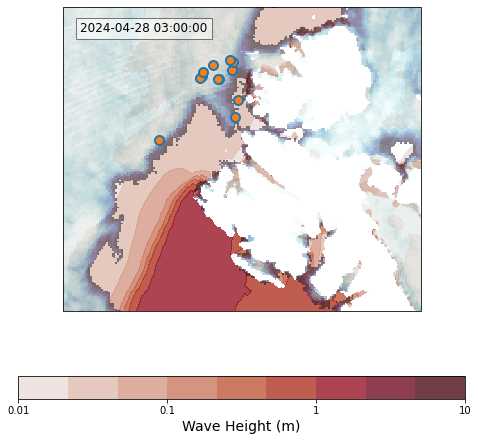

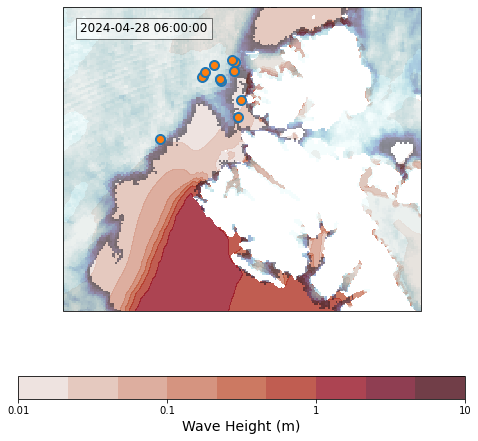

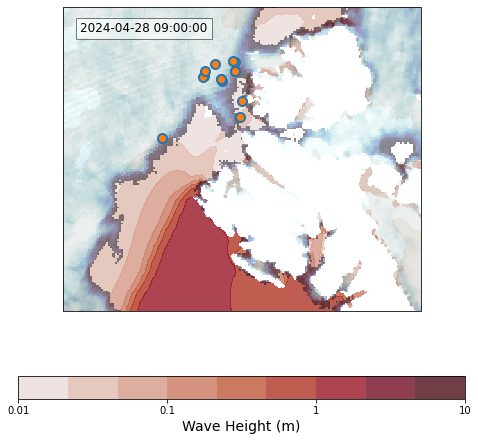

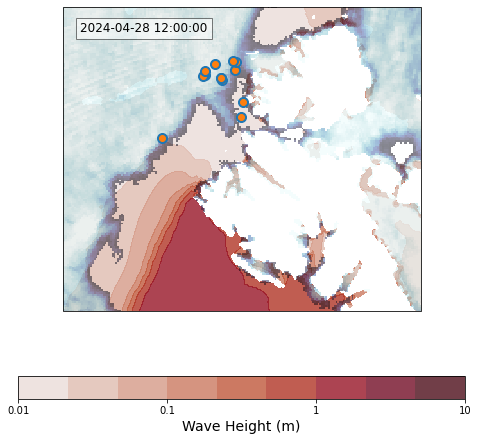

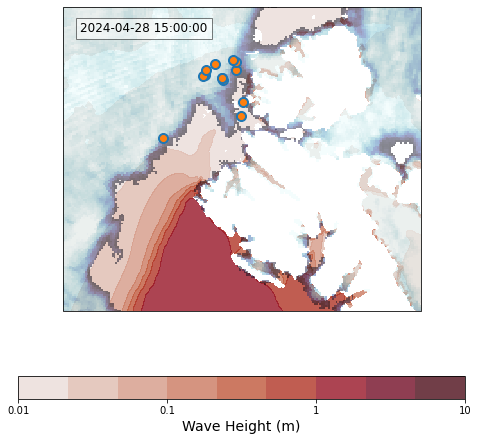

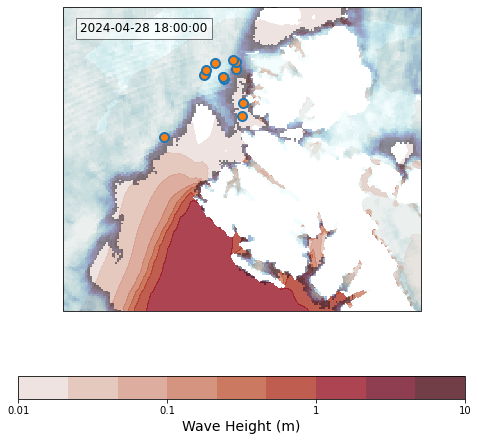

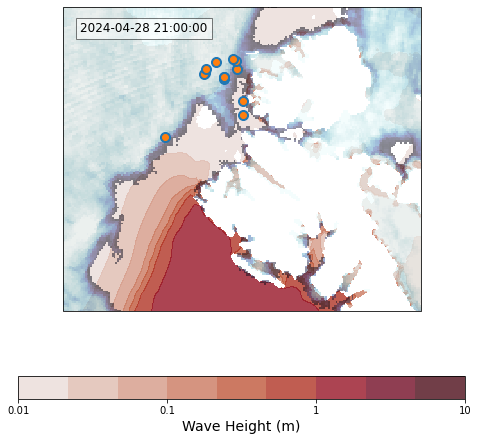

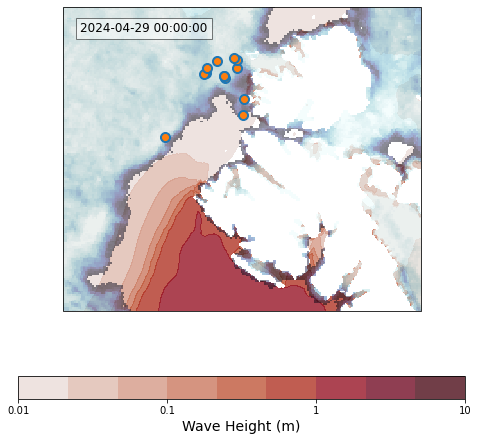

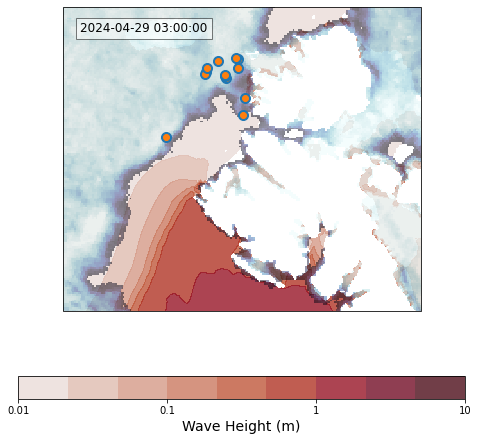

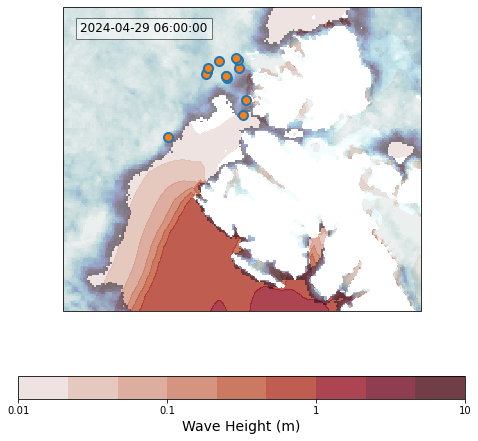

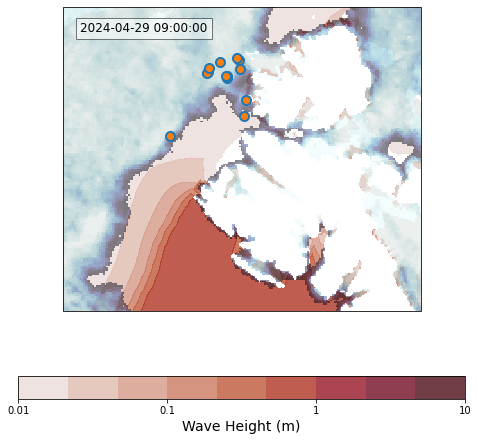

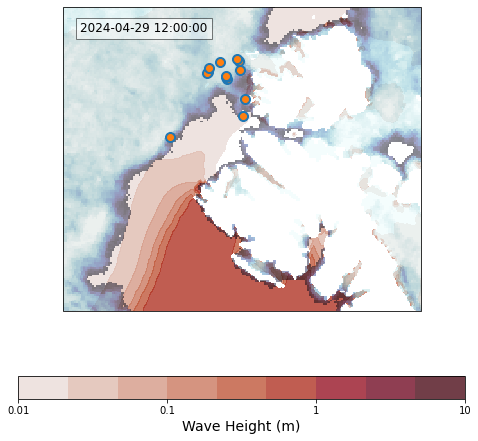

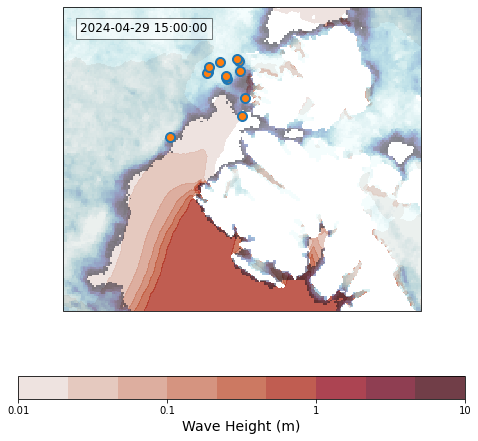

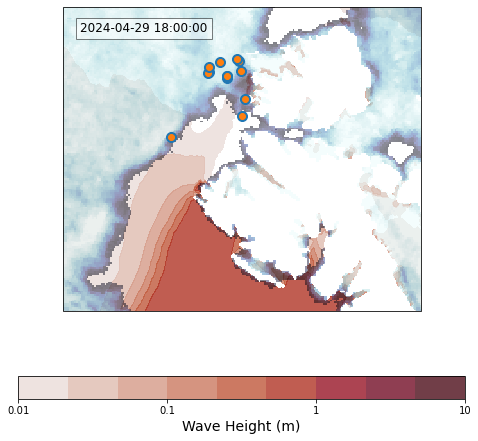

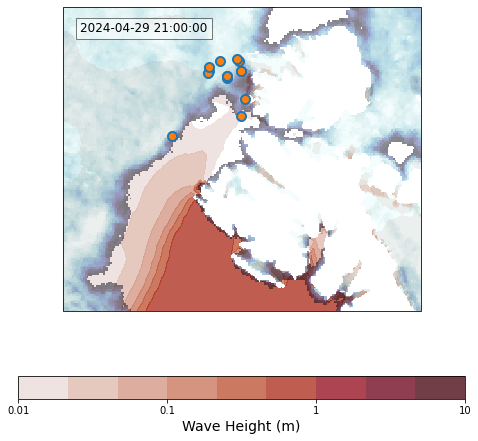

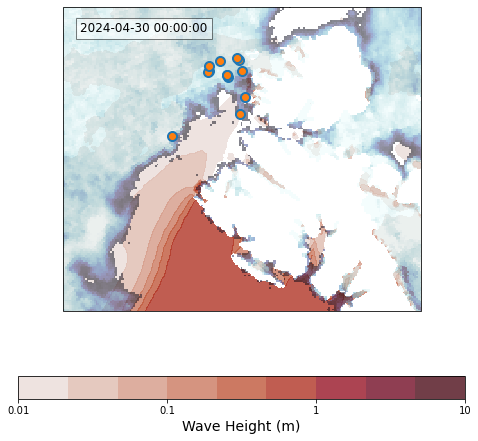

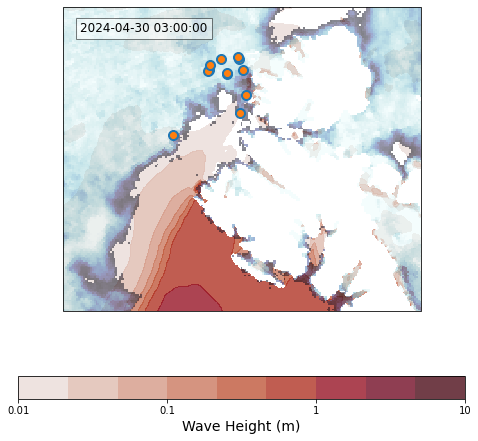

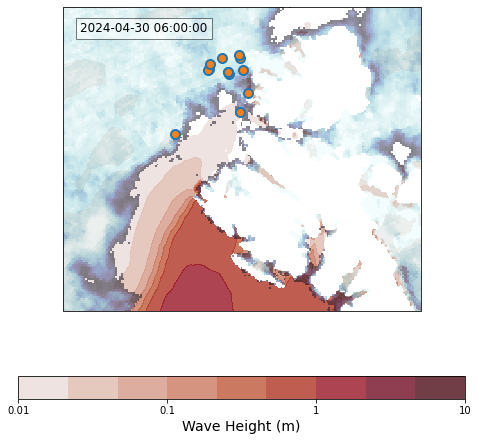

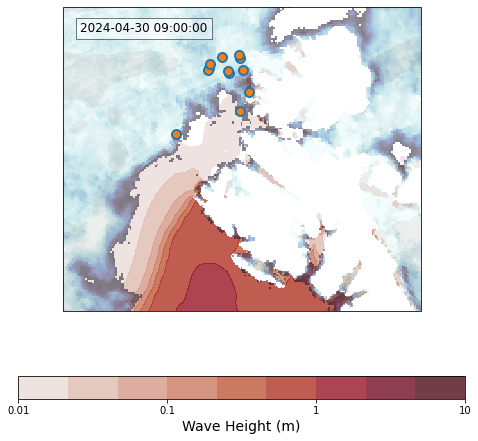

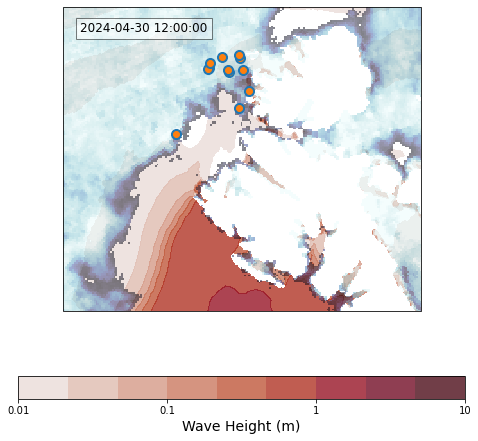

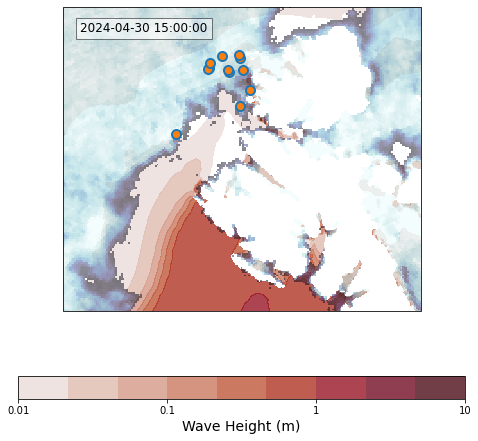

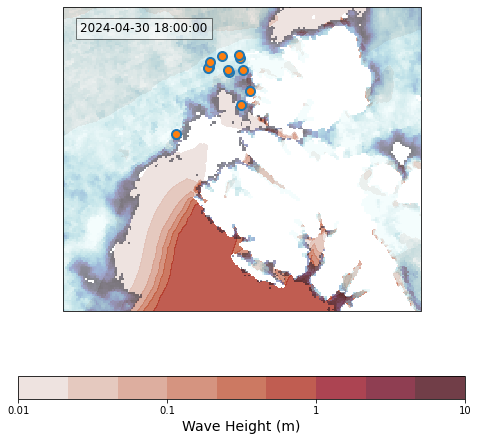

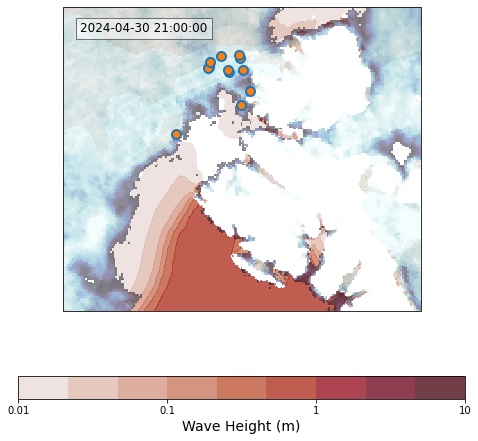

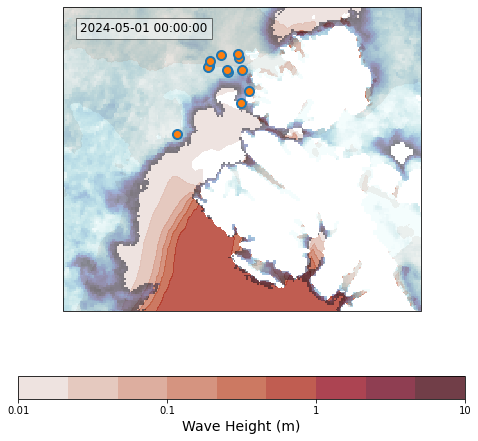

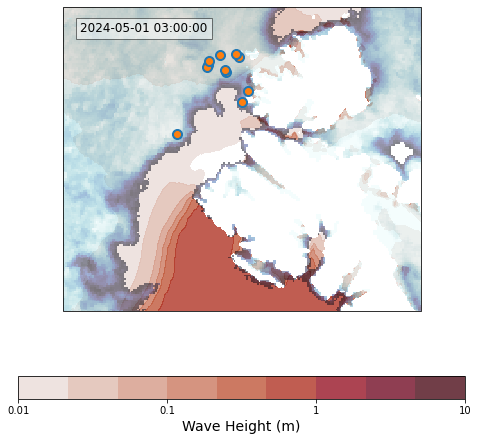

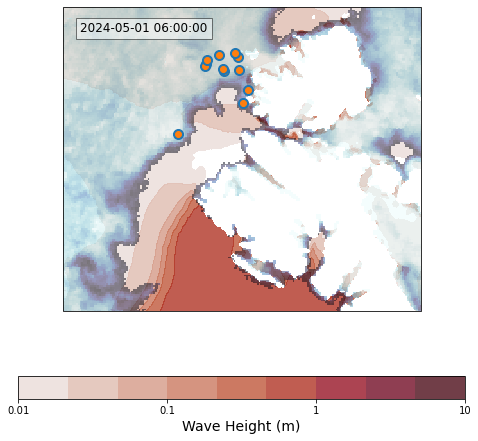

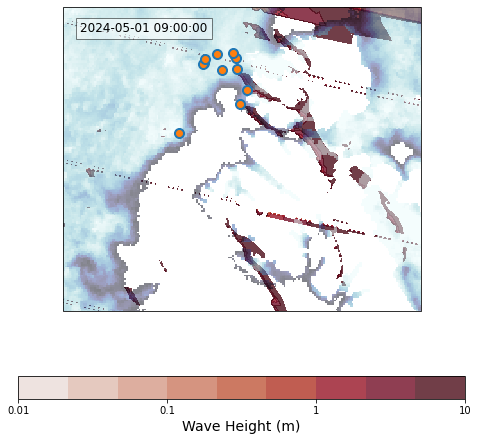

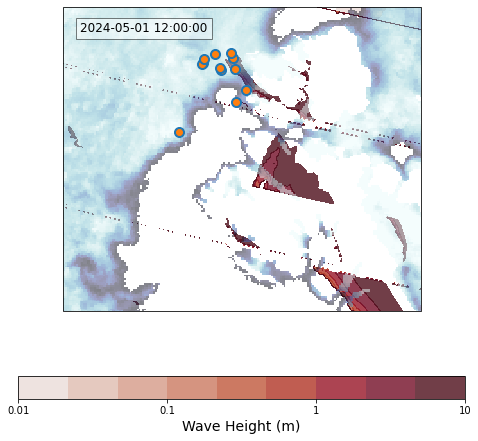

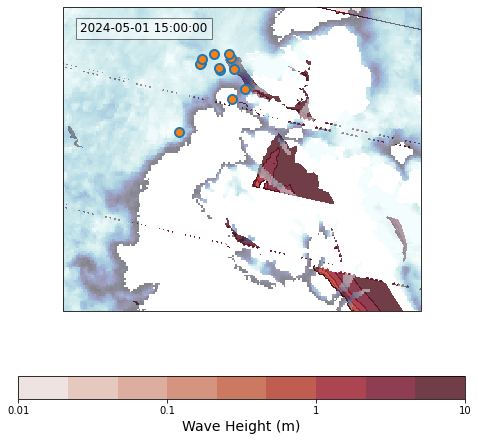

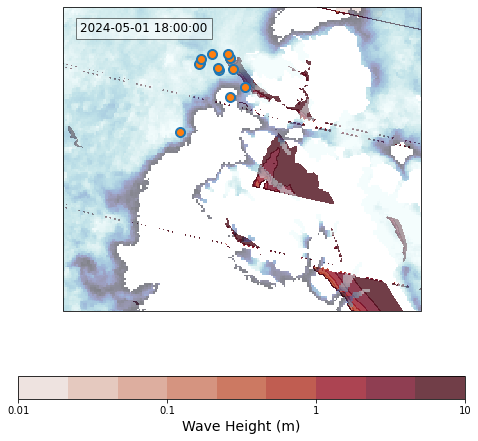

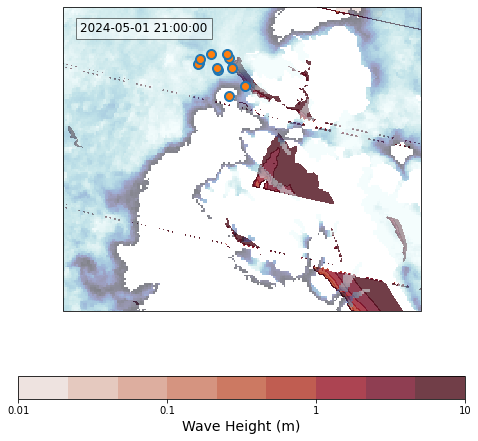

In [9]:
#------------------------------------------------------------#
# Input AROME Arctic File reduced to MIZ
AAbox = xr.open_mfdataset('data/AromeArctic/box.fc.diag.svalmiz2024.nc')
aboxlat=np.array(AAbox['latitude'])
aboxlon=np.array(AAbox['longitude'])

#------------------------------------------------------------#
# Input WAM Arctic File reduced to MIZ
WAM   = xr.open_mfdataset('Out.nc')

startdate = datetime.strptime('2024-04-24 00:00:00','%Y-%m-%d %H:%M:%S') 
timesteps_to_loop=8*8

for dt in range(timesteps_to_loop): #MAKE LOOP

    date = startdate + timedelta(hours=dt*3)

    #------------------------------------------------------------#
    #Find all buoys at date times closer than 29 minutes
    timenow = np.datetime64(date)
    timemask = np.int32(np.abs(np.array(OMBraw.time-timenow)).astype('timedelta64[m]'))<10

    #------------------------------------------------------------#
    # Load SeaIce             -----------------------------------#
    dir_seaiceproduct_hres= '/lustre/storeB/project/fou/hi/oper/barents_eps/archive/obs/'
    file_name_stub         = 'barents_icec-obs_%s' #barents_icec-obs_20240415T00Z.nc
    datetime_str = datetime.strftime(date, '%Y%m%d')
    file_prename = file_name_stub % datetime_str
    infile_name = glob.glob(dir_seaiceproduct_hres + file_prename + '*.nc')
    if infile_name:
        IceIn = xr.open_mfdataset(infile_name)
        lats = np.array(IceIn['lat'])
        lons = np.array(IceIn['lon'])
        sicn = np.array(IceIn['ice_conc'])
        sicn=np.where(sicn<0.1,np.nan,sicn)

    # Select wave field for the correct time    
    twave = np.argmin(np.array(np.abs(WAM.time-timenow)))
    hs = WAM.hs[twave,:,:]


    #  ---------- FIGURE ---------- #

    map_proj = ccrs.LambertConformal(central_latitude=77.5,
                                     central_longitude=-25,
                                     standard_parallels=(77.5,77.5))
    PRJ = pyproj.Proj(map_proj.proj4_init)
    x0,y0 = PRJ(alon[480,80],alat[480,80])
    x1,y1 = PRJ(alon[650,280],alat[650,280])

    # Define the rotated latitude-longitude projection
    rotated_pole_90 = ccrs.RotatedPole(pole_longitude=140, pole_latitude=25)

    # Define the Lambert Conformal projection
    map_proj = ccrs.LambertConformal(central_latitude=77.5,
                                 central_longitude=-25,
                                 standard_parallels=(77.5, 77.5))

    # Prepare the Lambert Conformal projection
    PRJ = pyproj.Proj(map_proj.proj4_init)
    x0, y0 = PRJ(alon[480, 80], alat[480, 80])
    x1, y1 = PRJ(alon[650, 280], alat[650, 280])

    LAND_highres = NaturalEarthFeature('physical', 'land', '50m', edgecolor='face',
                                            facecolor='darkgrey', linewidth=.1)

    fig, axs = plt.subplots(1, 1, figsize=(8, 8), facecolor='w', edgecolor='k')
    fig.subplots_adjust(hspace=0.1, wspace=0.3)

    #Define the levels for hs
    levels = np.logspace(-2, 1, num=10)  # from 0.01 to 10

    axs = plt.subplot(1, 1, 1, projection=map_proj)
    axs.set_title('', fontsize=18)

    # Plot the variable hs using xarray's plot method on top of the sea ice concentration
    waveplot = axs.contourf(WAM.rlon, WAM.rlat, np.squeeze(hs), levels=levels, norm=LogNorm(vmin=0.01, vmax=10), cmap=cmocean.cm.amp, transform=rotated_pole_90, alpha=0.8)

    # Plot the sea ice concentration
    iceplot = axs.pcolormesh(lons, lats, np.squeeze(np.array(sicn)) * 100., cmap=cmocean.cm.ice, transform=ccrs.PlateCarree(), alpha=0.5)

    # Plot the buoys
    for buoy_no in range(np.min(np.shape(timemask))):
        tb = np.where(timemask[buoy_no,:]); #tb = [x[0] for x in tb1]
        if tb:
            #print(np.array(OMBraw.time[buoy_no,np.array(tb[0])]),  np.array(OMBraw.lon[buoy_no,np.array(tb[0])]),np.array(OMBraw.lat[buoy_no,np.array(tb[0])]))
            axs.scatter(OMBraw.lon[buoy_no,np.array(tb[0])],OMBraw.lat[buoy_no,np.array(tb[0])],s=100,color='C0',marker='o',transform = ccrs.PlateCarree())
            axs.scatter(OMBraw.lon[buoy_no,np.array(tb[0])],OMBraw.lat[buoy_no,np.array(tb[0])],color='C1',marker='o',transform = ccrs.PlateCarree())

    # Add coastlines and other feature|s
   # axs.add_feature(cfeature.COASTLINE)

    # Add colorbar for wave heights
    cb = plt.colorbar(waveplot, ax=axs, orientation='horizontal', extend='both', ticks=[0.01, 0.1, 1, 10])
    cb.set_label('Wave Height (m)', size=14)
    cb.ax.set_xticklabels(['0.01', '0.1', '1', '10'])  # Set the labels for the logarithmic scale

    # Add a text box in the upper left corner with the date
    date_str = date.strftime('%Y-%m-%d %H:%M:%S')
    axs.text(0.05, 0.95, date_str, transform=axs.transAxes, fontsize=12,
             verticalalignment='top', bbox=dict(facecolor='white', alpha=0.5))

    axs.set_xlim(x0,x1)
    axs.set_ylim(y0,y1)
    plt.show()
    fig.savefig(date_str+'OMB_SvalMIZ2024.png')

In [10]:
infile_name

['/lustre/storeB/project/fou/hi/oper/barents_eps/archive/obs/barents_icec-obs_20240501T00Z.nc']